In [9]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
RES_DIR1 = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/default/final_results2/"
RES_DIR2 = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/default/large_bitmap/"

#RES_DIR2 = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/subq_imp2"

SAVE_DIR ="./figures/results2/"
make_dir(SAVE_DIR)
FN_TMP = "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}.png"

COLORS = {}
COLORS["Flow Loss"] = "blue"
COLORS["Q-Error"] = "green"

In [11]:
def arg_filters(df):
    #tmp = df2[df2["template"] == "all_job"]
    #tmp = tmp[tmp["partition"] == 2]
    #tmp = tmp[tmp["alg"] == "flow_loss2"]
    tmp = df[df["flow_features"] == 1]
    tmp = tmp[tmp["hidden_layer_size"] == 512]
    tmp = tmp[tmp["feat_rel_pg_ests_onehot"] == 1]
    return tmp

In [12]:
#df1 = get_all_objects(RES_DIR, "query_qerr.pkl")
#df3 = get_all_objects(RES_DIR, "flow_err.pkl")

RES_DIRS = []
RES_DIRS.append(RES_DIR1)
#RES_DIRS.append(RES_DIR2)

df1s = []
df2s = []
for res_dir in RES_DIRS:
    qerr = get_all_objects(res_dir, "all_qerr.pkl")
    jerr = get_all_objects(res_dir, "cm1_jerr.pkl")
    df1s.append(qerr)
    df2s.append(jerr)
    
df1 = pd.concat(df1s, ignore_index=True)
df2 = pd.concat(df2s, ignore_index=True)

In [13]:
#df1 = arg_filters(df1)
#df2 = arg_filters(df2)
#len(df2) == len(df1)

# FIXME: this should not happen
#df1 = df1[~df1.qerr.isna()]
#df2 = df2[~df2.loss.isna()]

print(len(df2), len(df1))
ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Flow Loss"
ALG_KEY["mse"] = "Q-Error"


27212 6807966


In [14]:
#print(set(df["samples_type"]))

In [15]:
set(df2["samples_type"])
print(set(df2["alg"]))
df2["alg_name"] = df2.apply(lambda x: x["alg"]+ str(x["sample_bitmap"]), axis=1)
print(set(df2["alg_name"]))

{'mse', 'flow_loss2'}
{'mse0', 'flow_loss20'}


In [16]:
def compute_PDF(arr, num_bins=600):
    """
    usage: x, y = compute_PDF(arr):
           plt.plot(x, y)
    """
    values, base = np.histogram(arr, bins=num_bins)
    cumulative = np.cumsum(values)
    return base[:-1], cumulative / float(cumulative[-1])  # this is for CDF

In [17]:
#TITLE_FMT = "{SAMPLES}-{PARTITION}"
TITLE_KEYS = {}
TITLE_KEYS["job"] = "Join Order Benchmark"
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

def plot_cdf_jerr(samples_type, df, part):
    #plt.gcf()
    fn = FN_TMP.format(ERROR_TYPE = "postgres",
                       SAMPLES_TYPE = st,
                       PART = part)
    fn = SAVE_DIR + fn
    #plt.figure(figsize=(5,4))
    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')   

    df = df[df.samples_type == samples_type]
    algs = set(df["alg"])
    
    plt.title(TITLE_KEYS[samples_type] + "-" + str(part))

    for alg in algs:
        if alg == "true" or alg == "postgres":
            continue
        tmp_df = df[df.alg == alg]
        
        alg_label = ALG_KEY[alg]

        losses = tmp_df["loss"].values
        #x, y = compute_PDF(losses, num_bins=len(losses))
        x, y = compute_PDF(losses, num_bins=len(losses))
        plt.plot(x, y, label = alg_label, linestyle="--", linewidth=3, color = COLORS[alg_label])
        plt.xscale("symlog")
        plt.legend(frameon=False)
    plt.savefig(fn)
    plt.show()

def plot_cdf_qerr(samples_type, df,part):
    fn = FN_TMP.format(ERROR_TYPE = "qerror",
                       SAMPLES_TYPE = st,
                       PART = part)
    fn = SAVE_DIR + fn

    plt.figure(figsize=(5,4))
    plt.title(TITLE_KEYS[samples_type] + "-" + str(part))
    
    algs = set(df["alg"])
    for alg in algs:
        if alg == "true" or alg == "postgres":
            continue
        #alg = ALG_KEYS[alg]
        tmp_df = df[df.alg == alg]
        
        alg_label = ALG_KEY[alg]

        #losses = tmp_df["qerr"].values
        losses = tmp_df["loss"].values
        x, y = compute_PDF(losses, num_bins=600)
        plt.plot(x, y, label = alg_label, linestyle="--", linewidth=3, color = COLORS[alg_label])
        plt.xscale("symlog")
        #plt.ylim([None, 0.999])
        #plt.xlim([1.0,1000.0])
        #plt.yscale("log")
        plt.legend(frameon=False)
    plt.savefig(fn)
    plt.show()


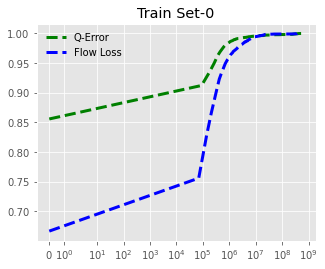

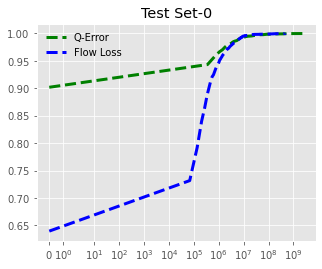

In [18]:
SAMPLES_TYPES = ["train", "test"]
#SAMPLES_TYPES = ["test", "job"]

for st in SAMPLES_TYPES:
    for part in set(df2["partition"]):
        tmp_df = df2[df2.partition == part]
        plot_cdf_jerr(st, tmp_df, part)

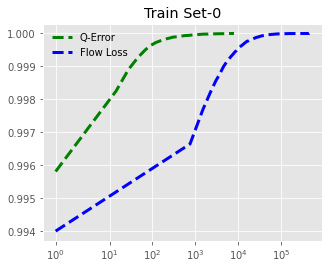

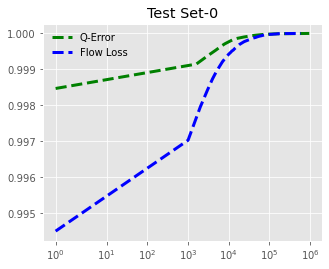

In [19]:
# for part in set(df1["partition"]):
#     tmp_df = df1[df1.partition == part]
#     plot_cdf_qerr("test", tmp_df)

for st in SAMPLES_TYPES:
    cur_df = df1[df1.samples_type == st]
    for part in set(df1["partition"]):
        tmp_df = cur_df[cur_df.partition == part]
        plot_cdf_qerr(st, tmp_df, part)

In [20]:
tmp = df2[df2["template"] == "all_job"]
tmp = tmp[tmp["partition"] == 2]
tmp = tmp[tmp["alg"] == "flow_loss2"]
tmp = tmp[tmp["flow_features"] == 1]
tmp = tmp[tmp["feat_rel_pg_ests_onehot"] == 1]

KeyError: 'feat_rel_pg_ests_onehot'

In [21]:
print(len(tmp))
print(set(tmp["num_hidden_layers"]))
print(set(tmp["hidden_layer_size"]))
print(set(tmp["flow_features"]))
print(set(tmp["feat_rel_pg_ests_onehot"]))

0


KeyError: 'num_hidden_layers'

In [25]:
sdf = df2.sort_values(by="loss", ascending=False)
sdf[["loss", "template","samples_type", "alg"]].head(20)

,loss,template,samples_type,alg
10588,2.386220e+09,9a,test,mse
12437,7.392958e+08,9a,test,mse
1852,6.130389e+08,9a,train,mse
9174,6.041250e+08,9a,test,mse
12592,4.974815e+08,9a,test,mse
1947,4.782442e+08,9a,train,flow_loss2
6976,4.601467e+08,9b,test,flow_loss2
4517,4.103318e+08,9a,train,mse
10234,3.990362e+08,9a,test,mse
1373,3.799229e+08,9a,train,mse
